In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


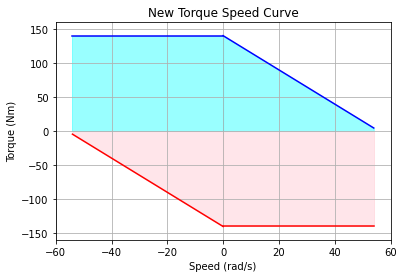

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

<a id='Select_Test'></a>

In [4]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run_Flight",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop"}

test = tests[8]
V_avg = 8.0
mu_value = 1.0
h_lower_bound = 0.8
h_higher_bound = 1.2

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.2
elif test == "High_Drop_Move_Leg":
    N = 50
    TT = 0.4
elif test == "Forward_Hop":
    N = 50
    TT = 0.7
    x_final = 2.0 # for display
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 100 #100
    TT = 0.3 #0.5 #0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
    
elif test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run":
    
    import csv
    file = open(str(round(V_avg))+'.csv')
    csvreader = csv.reader(file)
        
    rows = []
    for row in csvreader:
        rows.append(row)
    
    stored_values = {}
    headers = rows[0]
    
    for item in rows:
        if item[0] == 'node': # remove headers
            pass
        else: 
            for header_loc in range(len(headers)):
                if header_loc == 0: # don't want 'node' as header - only its value
                    pass 
                else:
                    stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})
        
        #initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 
    
    if test == "Stop_Periodic_Run_Flight":
        # done [100,1.5 and ]
        N = 100 #50
        TT = 1.2 # 1.0 2Hz but only half a gait due to symmetry
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   
    
else:
    pass



In [5]:
print("test = ",test)
print("total mass = " ,total_mass)
print("mu = ",mu_value)
print("V_avg = ",V_avg)
print("N = ",N)
print("TT = ",TT)

if TT/N < 0.01 or TT/N>0.02:
    print('Exceeded hm: ',TT/N)
else:
    print('Passed hm: ',TT/N)
    


test =  Periodic_Run
total mass =  7.75782
mu =  1.0
V_avg =  8.0
N =  100
TT =  0.3
Exceeded hm:  0.003


In [6]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [7]:
''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_lower_bound,h_higher_bound)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [9]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [10]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [11]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [12]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [13]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)       
    
    else:
        if test == "Forward_Hop":
            m.q[n,'y_body'].setub(2.0)
        else: pass
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]

<a id='initial_conditions'></a>

In [14]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    

elif test == "Stop_Periodic_Run_Flight":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    
    m.q[1,'x_body'].fix(stored_values['x_body',0]) # initial condition
    m.q[1,'y_body'].fix(stored_values['y_body',0])
    m.q[1,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.GRF_y[1,'A'].fix(0.0)
    m.GRF_y[1,'B'].fix(0.0)
    
    m.dq[1,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[1,'y_body'].fix(stored_values['dy_body',0])
    m.dq[1,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
    # initial condition

    m.q[N,'y_body'].fix(stored_values['y_body',0])
    m.q[N,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[N,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[N,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[N,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[N,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[N,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[N,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[N,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[N,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.dq[N,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[N,'y_body'].fix(stored_values['dy_body',0])
    m.dq[N,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[N,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[N,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[N,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[N,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[N,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[N,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[N,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[N,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
    

else: pass

In [15]:
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)

In [16]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run_Flight":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [17]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [18]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [19]:
# solving
opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    45349
Number of nonzeros in inequality constraint Jacobian.:     3986
Number of nonzeros in Lagrangian Hessian.............:    24767

Total number of variables............................:     8191
                     variables with only lower bounds:      800
                variables with lower and upper bounds:     3893
                     variables with only u

  77  1.8765925e+06 6.87e+01 2.44e+06  -1.0 1.98e+01   2.9 6.36e-03 9.48e-04h  1
  78  1.8910595e+06 6.86e+01 2.43e+06  -1.0 2.66e+01   2.4 6.31e-04 1.10e-03h  1
  79  1.8933770e+06 6.86e+01 2.60e+06  -1.0 1.98e+01   2.9 9.88e-03 3.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.9215260e+06 6.84e+01 2.60e+06  -1.0 3.60e+01   2.4 2.20e-03 2.00e-03h  1
  81  1.9387964e+06 6.83e+01 2.86e+06  -1.0 1.98e+01   2.8 1.75e-02 2.27e-03h  1
  82  1.9545936e+06 6.82e+01 2.90e+06  -1.0 5.41e+01   2.3 3.69e-03 1.08e-03h  1
  83  1.9615019e+06 6.82e+01 2.89e+06  -1.0 1.96e+01   2.8 2.39e-04 8.58e-04h  1
  84  1.9703356e+06 6.81e+01 2.91e+06  -1.0 1.20e+02   2.3 1.87e-03 5.73e-04h  1
  85  1.9908152e+06 6.80e+01 2.91e+06  -1.0 1.98e+01   2.7 2.78e-03 2.38e-03h  1
  86  2.0063155e+06 6.77e+01 3.13e+06  -1.0 1.69e+01   3.1 1.59e-02 3.46e-03h  1
  87  2.0264677e+06 6.76e+01 3.09e+06  -1.0 1.98e+01   2.7 1.02e-04 2.27e-03h  1
  88  2.0335775e+06 6.75e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  7.8875042e+06 3.30e+01 1.68e+06  -1.0 1.60e+01   1.9 5.36e-02 6.93e-03h  1
 171  8.2407352e+06 3.26e+01 1.66e+06  -1.0 2.84e+01   1.4 1.19e-02 1.35e-02h  1
 172  8.3211488e+06 3.24e+01 1.65e+06  -1.0 1.64e+01   1.8 7.90e-03 5.22e-03h  1
 173  8.5224350e+06 3.21e+01 1.65e+06  -1.0 3.14e+01   1.4 1.55e-03 7.48e-03h  1
 174  8.5867965e+06 3.20e+01 1.65e+06  -1.0 1.72e+01   1.8 1.04e-02 3.95e-03h  1
 175  8.7585869e+06 3.18e+01 1.63e+06  -1.0 3.71e+01   1.3 1.14e-02 6.38e-03h  1
 176  8.8574481e+06 3.16e+01 1.63e+06  -1.0 1.78e+01   1.7 1.20e-02 5.94e-03h  1
 177  8.9446331e+06 3.15e+01 1.62e+06  -1.0 6.14e+01   1.3 6.15e-03 4.09e-03h  1
 178  8.9502176e+06 3.15e+01 1.63e+06  -1.0 1.67e+01   1.7 8.82e-03 1.27e-03h  1
 179  8.9647287e+06 3.12e+01 1.62e+06  -1.0 1.20e+02   1.2 5.04e-03 8.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  8.9824831e+06 3.11e+01

 289r 2.3388696e+07 1.49e+00 1.14e+02  -0.6 1.41e-01   2.7 1.00e+00 7.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 2.3389985e+07 1.49e+00 1.02e+02  -0.6 2.82e+00   2.2 6.09e-02 2.01e-02f  1
 291r 2.3417877e+07 1.49e+00 2.11e+02  -0.6 5.62e-01   1.7 4.38e-01 1.62e-01f  1
 292r 2.3483492e+07 1.49e+00 3.79e+01  -0.6 2.08e-01   2.1 1.00e+00 9.95e-01f  1
 293r 2.3526947e+07 1.49e+00 4.70e+02  -0.6 1.90e+00   1.6 3.77e-02 2.10e-01f  1
 294r 2.3528312e+07 1.49e+00 4.16e+02  -0.6 1.03e-01   3.0 1.00e+00 1.45e-01f  1
 295r 2.3534894e+07 1.49e+00 4.51e+02  -0.6 1.16e-01   2.5 1.00e+00 2.37e-01f  1
 296r 2.3578494e+07 1.49e+00 2.82e+02  -0.6 2.93e-01   2.0 1.00e+00 5.23e-01f  1
 297r 2.3610016e+07 1.49e+00 3.14e+01  -0.6 1.15e-01   2.4 1.00e+00 1.00e+00f  1
 298r 2.3621832e+07 1.49e+00 3.18e+01  -0.6 4.24e-02   2.9 1.00e+00 1.00e+00f  1
 299r 2.3628611e+07 1.49e+00 4.64e+01  -0.6 4.54e-01   2.4 2.41e-01 1.88e-01f  1
iter    objective    inf_pr 

 426r 2.8577562e+07 6.08e-01 1.16e+02  -1.3 1.29e+00   1.4 4.75e-01 2.88e-01f  1
 427r 2.8575789e+07 5.93e-01 1.90e+02  -1.3 3.69e-01   1.8 1.00e+00 5.78e-01f  1
 428r 2.8575406e+07 5.92e-01 2.02e+02  -1.3 3.63e+01   1.4 2.02e-02 5.33e-03f  1
 429r 2.8575089e+07 5.89e-01 5.42e+02  -1.3 4.66e-01   1.8 1.00e+00 8.70e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430r 2.8573677e+07 5.59e-01 4.18e+02  -1.3 1.14e+00   1.3 1.94e-01 2.22e-01f  1
 431r 2.8572403e+07 5.45e-01 3.21e+02  -1.3 3.91e-01   1.7 7.44e-01 3.50e-01f  1
 432r 2.8571695e+07 5.34e-01 3.10e+02  -1.3 1.61e+00   1.3 7.82e-02 5.42e-02f  1
 433r 2.8570844e+07 5.23e-01 3.59e+02  -1.3 4.76e-01   1.7 5.52e-01 2.02e-01f  1
 434r 2.8570460e+07 5.13e-01 3.35e+02  -1.3 2.06e+00   1.2 3.23e-02 3.58e-02f  1
 435r 2.8569120e+07 4.89e-01 5.89e+02  -1.3 5.76e-01   1.6 6.41e-01 3.70e-01f  1
 436r 2.8568488e+07 4.67e-01 5.53e+02  -1.3 2.85e+00   1.1 6.80e-02 5.44e-02f  1
 437r 2.8565715e+07 4.47e-01

 564r 2.8024613e+07 4.04e-01 2.10e+02  -1.3 2.85e-01   1.5 3.81e-01 2.41e-01f  1
 565r 2.8005834e+07 4.07e-01 2.40e+02  -1.3 7.91e-01   1.0 1.36e-01 1.04e-01f  1
 566r 2.7952826e+07 4.09e-01 2.59e+02  -1.3 2.12e+00   0.5 1.47e-01 1.02e-01f  1
 567r 2.7929155e+07 4.11e-01 2.99e+02  -1.3 8.53e-01   1.0 2.53e-01 1.19e-01f  1
 568r 2.7833895e+07 4.12e-01 1.89e+02  -1.3 2.35e+00   0.5 8.22e-02 1.58e-01f  1
 569r 2.7822394e+07 4.06e-01 2.05e+02  -1.3 3.47e+01   0.0 1.72e-03 3.17e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570r 2.7814712e+07 4.05e-01 2.58e+02  -1.3 2.39e+00   0.4 1.22e-01 1.15e-02f  1
 571r 2.7788982e+07 4.05e-01 2.05e+02  -1.3 9.91e-01   0.9 2.05e-01 1.10e-01f  1
 572r 2.7749268e+07 4.02e-01 1.92e+02  -1.3 2.39e+00   0.4 9.29e-02 7.39e-02f  1
 573r 2.7692748e+07 4.04e-01 2.24e+02  -1.3 1.04e+00   0.8 1.38e-01 2.68e-01f  1
 574r 2.7665248e+07 4.03e-01 4.79e+02  -1.3 2.66e+00   0.3 3.61e-01 5.06e-02f  1
 575r 2.7594267e+07 4.03e-01

 677  2.3337276e+07 5.51e-02 2.84e+02  -1.0 3.10e+04    -  2.14e-04 7.72e-04f  1
 678  2.2489352e+07 7.27e-02 1.74e+02  -1.0 3.56e+04    -  6.85e-03 4.01e-03f  1
 679  2.0650226e+07 9.77e-02 2.46e+02  -1.0 6.74e+04    -  1.80e-04 2.63e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  1.7899418e+07 1.35e-01 2.74e+02  -1.0 9.20e+04    -  1.35e-03 2.36e-03f  1
 681  1.3767122e+07 2.14e-01 3.86e+02  -1.0 6.28e+04    -  1.12e-04 4.28e-03f  1
 682  1.3693432e+07 2.14e-01 3.20e+02  -1.0 5.19e+04    -  2.66e-03 9.95e-05f  1
 683  1.0655827e+07 3.54e-01 4.08e+02  -1.0 5.06e+04    -  1.08e-03 4.67e-03f  1
 684  9.5329658e+06 3.82e-01 2.40e+02  -1.0 3.92e+04    -  9.44e-03 2.34e-03f  1
 685  4.8505469e+06 2.07e+00 4.79e+02  -1.0 3.17e+04    -  3.57e-03 1.51e-02f  1
 686  2.3597013e+06 2.56e+00 7.35e+02  -1.0 2.23e+04    -  3.89e-03 1.80e-02f  1
 687  7.7745124e+05 1.92e+00 9.40e+02  -1.0 2.15e+04    -  1.38e-02 2.73e-02f  1
 688  6.1197529e+05 2.66e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  4.3751017e+05 1.44e+00 1.26e+04  -1.0 1.30e+01   1.3 1.48e-02 1.50e-02h  2
 771  4.4966778e+05 1.44e+00 1.45e+04  -1.0 2.59e+01   0.9 6.84e-03 2.06e-03h  3
 772  4.5312810e+05 1.44e+00 1.55e+04  -1.0 4.66e+01   0.4 4.08e-03 2.95e-04h  6
 773  4.5590835e+05 1.44e+00 1.69e+04  -1.0 2.74e+01   0.8 4.27e-03 3.30e-04h  6
 774  4.5632208e+05 1.44e+00 1.76e+04  -1.0 4.72e+01   0.3 3.16e-03 2.61e-05h 10
 775  5.4839086e+05 1.42e+00 1.57e+04  -1.0 2.92e+01   0.8 3.87e-03 9.07e-03h  1
 776  8.4416379e+05 1.40e+00 1.36e+04  -1.0 4.76e+01   0.3 6.04e-03 1.50e-02h  1
 777  1.1267968e+06 1.39e+00 1.28e+04  -1.0 7.83e+01  -0.2 3.80e-03 9.36e-03h  1
 778  1.1325546e+06 1.39e+00 1.81e+04  -1.0 1.60e+01   1.1 1.40e-02 9.48e-04h  1
 779  1.1556493e+06 1.38e+00 2.09e+04  -1.0 9.28e+00   1.6 1.44e-02 8.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  1.2649052e+06 1.35e+00

 862  2.1795797e+07 3.36e-01 4.69e+04  -1.0 1.15e+02  -0.1 1.51e-02 1.55e-02h  1
 863  2.2255231e+07 3.30e-01 4.55e+04  -1.0 5.04e+01   0.3 2.03e-02 1.87e-02h  1
 864  2.2873431e+07 3.25e-01 4.49e+04  -1.0 1.32e+02  -0.2 1.48e-02 1.43e-02h  1
 865  2.3276214e+07 3.19e-01 4.42e+04  -1.0 5.67e+01   0.3 1.71e-02 1.77e-02h  1
 866  2.4132389e+07 3.12e-01 4.28e+04  -1.0 1.50e+02  -0.2 1.40e-02 2.25e-02h  1
 867  2.4502426e+07 3.06e-01 4.17e+04  -1.0 6.40e+01   0.2 2.03e-02 1.92e-02h  1
 868  2.5159082e+07 2.98e-01 4.07e+04  -1.0 1.71e+02  -0.3 2.19e-02 2.25e-02h  1
 869  2.5459223e+07 2.92e-01 3.93e+04  -1.0 7.15e+01   0.2 2.19e-02 1.90e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  2.5928784e+07 2.86e-01 4.03e+04  -1.0 1.94e+02  -0.3 1.07e-02 2.05e-02h  1
 871  2.6235062e+07 2.79e-01 4.04e+04  -1.0 8.03e+01   0.1 2.03e-02 2.18e-02h  1
 872  2.6751780e+07 2.70e-01 4.65e+04  -1.0 2.19e+02  -0.4 2.21e-02 2.83e-02h  1
 873  2.6964678e+07 2.65e-01

 955  3.9016582e+07 2.91e-03 8.01e+05  -1.7 1.61e+00   2.5 1.00e+00 4.41e-03h  1
 956  3.9172469e+07 2.91e-03 4.81e+02  -1.7 6.05e-01   2.9 1.00e+00 1.00e+00h  1
 957  3.9198368e+07 2.90e-03 7.65e+05  -1.7 1.96e+00   2.4 1.00e+00 4.92e-02h  1
 958  3.9201837e+07 2.90e-03 7.90e+05  -1.7 7.38e-01   2.8 1.00e+00 1.82e-02h  1
 959  3.9225317e+07 2.90e-03 7.71e+05  -1.7 2.22e+00   2.4 1.00e+00 4.10e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  3.9297838e+07 2.90e-03 5.33e+05  -1.7 8.34e-01   2.8 1.00e+00 3.38e-01h  1
 961  3.9301838e+07 2.90e-03 7.65e+05  -1.7 3.21e-01   3.2 1.00e+00 4.99e-02h  1
 962  3.9478623e+07 2.89e-03 4.41e+05  -1.7 9.65e-01   2.7 1.00e+00 6.84e-01H  1
 963  3.9480464e+07 2.89e-03 7.90e+05  -1.7 3.92e-01   3.2 1.00e+00 1.82e-02h  1
 964  3.9595567e+07 2.88e-03 4.85e+05  -1.7 1.18e+00   2.7 1.00e+00 3.99e-01h  1
 965  3.9596854e+07 2.88e-03 7.96e+05  -1.7 4.54e-01   3.1 1.00e+00 1.15e-02h  1
 966  3.9652940e+07 2.88e-03

1048  4.1767613e+07 2.78e-03 2.07e+03  -1.7 1.44e-01   4.2 1.00e+00 1.00e+00h  1
1049  4.1769635e+07 2.78e-03 4.45e+05  -1.7 4.38e-01   3.7 8.14e-01 8.17e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050  4.1779075e+07 2.78e-03 2.15e+03  -1.7 1.65e-01   4.1 1.00e+00 1.00e+00H  1
1051r 4.1779075e+07 2.78e-03 1.00e+03  -1.7 0.00e+00   3.6 0.00e+00 3.11e-07R 20
1052r 4.1868536e+07 9.27e-01 1.08e+03  -1.7 7.19e+04    -  2.68e-02 9.25e-03f  1
1053r 4.1890682e+07 1.11e+00 1.28e+03  -1.7 5.34e+04    -  4.24e-02 6.66e-03f  1
1054r 4.1895759e+07 3.29e+00 1.34e+03  -1.7 4.61e+04    -  6.41e-02 2.82e-02f  1
1055r 4.1858245e+07 4.26e+00 1.30e+03  -1.7 3.12e+04    -  3.32e-02 2.84e-02f  1
1056r 4.1822163e+07 5.23e+00 1.26e+03  -1.7 3.09e+04    -  9.03e-02 3.10e-02f  1
1057r 4.1792100e+07 5.88e+00 1.21e+03  -1.7 2.47e+04    -  8.92e-02 3.78e-02f  1
1058r 4.1745220e+07 6.94e+00 1.12e+03  -1.7 2.09e+04    -  8.00e-02 5.77e-02f  1
1059r 4.1714593e+07 6.99e+00

1141  3.5651320e+07 4.84e-02 1.16e+03  -1.7 1.18e+05    -  2.05e-04 1.36e-03f  1
1142  3.3906392e+07 6.11e-02 1.19e+03  -1.7 1.13e+05    -  3.13e-03 8.87e-04f  1
1143  3.2183770e+07 7.45e-02 1.17e+03  -1.7 9.72e+04    -  9.29e-05 1.07e-03f  1
1144  3.1556914e+07 7.62e-02 1.25e+03  -1.7 9.36e+04    -  7.67e-03 4.16e-04f  1
1145  2.3998304e+07 3.58e-01 1.18e+03  -1.7 7.23e+04    -  1.06e-04 6.83e-03f  1
1146  2.3837676e+07 3.58e-01 1.19e+03  -1.7 5.94e+04    -  1.31e-03 1.96e-04f  1
1147  1.8048788e+07 4.74e-01 1.12e+03  -1.7 5.44e+04    -  7.66e-04 7.41e-03f  1
1148  1.7115069e+07 4.78e-01 1.11e+03  -1.7 5.53e+04    -  1.14e-03 1.67e-03f  1
1149  1.3050755e+07 5.37e-01 1.04e+03  -1.7 5.12e+04    -  1.07e-04 7.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150  9.8331893e+06 5.63e-01 1.03e+03  -1.7 4.81e+04    -  8.70e-03 8.54e-03f  1
1151  7.4640774e+06 5.80e-01 9.95e+02  -1.7 3.90e+04    -  7.71e-03 1.09e-02f  1
1152  6.9606722e+06 5.82e-01

1234  3.1056845e+05 7.43e-04 2.75e+03  -2.5 2.19e-02   2.1 7.51e-01 1.00e+00h  1
1235  3.1061850e+05 7.43e-04 3.54e+03  -2.5 6.92e-02   1.6 1.00e+00 6.73e-01h  1
1236  3.1083923e+05 7.43e-04 1.21e+01  -2.5 2.15e-01   1.1 1.00e+00 1.00e+00h  1
1237  3.1130860e+05 7.44e-04 3.54e+03  -2.5 6.77e-01   0.6 5.47e-01 7.38e-01H  1
1238  3.1161637e+05 7.44e-04 4.55e+03  -2.5 2.67e-01   1.1 1.07e-01 2.37e-01h  1
1239  3.1177081e+05 7.44e-04 3.38e+03  -2.5 1.18e-01   1.5 1.32e-01 7.63e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240  3.1229968e+05 7.44e-04 2.85e+03  -2.5 3.94e-02   1.9 4.05e-01 4.86e-01h  1
1241  3.1237171e+05 7.44e-04 2.01e+03  -2.5 2.29e-01   1.4 7.18e-02 9.74e-03h  5
1242  3.1447566e+05 7.44e-04 9.83e+03  -2.5 4.67e-02   1.9 1.86e-01 5.86e-01H  1
1243  3.1567448e+05 7.44e-04 1.01e+04  -2.5 2.95e-02   2.3 2.90e-01 4.90e-01H  1
1244  3.1579834e+05 7.44e-04 7.28e+03  -2.5 1.86e-01   1.8 1.45e-01 1.26e-02h  3
1245  3.1686961e+05 7.44e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340r 7.1268436e+06 1.62e-02 3.79e+02  -5.7 7.92e+02  -6.0 1.53e-01 1.99e-02f  1
1341r 7.1912936e+06 1.61e-02 3.95e+02  -5.7 3.30e+02  -5.6 3.43e-02 1.60e-02h  1
1342r 7.3853771e+06 1.98e-02 5.07e+02  -5.7 8.77e+02  -6.1 1.56e-01 4.41e-02f  1
1343r 7.4562290e+06 1.96e-02 5.38e+02  -5.7 3.06e+02  -5.7 6.89e-02 2.09e-02h  1
1344r 7.5640557e+06 2.13e-02 5.18e+02  -5.7 7.41e+02  -6.1 2.80e-02 3.30e-02f  1
1345r 7.7358332e+06 2.23e-02 5.49e+02  -5.7 2.89e+02  -5.7 1.74e-01 6.10e-02h  1
1346r 7.8588710e+06 3.31e-02 5.22e+02  -5.7 7.74e+02  -6.2 1.14e-01 8.41e-02f  1
1347r 7.8588365e+06 3.31e-02 6.78e+02  -5.7 2.32e+02  -5.8 3.40e-01 3.81e-05h  1
1348r 7.7963905e+06 3.59e-02 6.95e+02  -5.7 6.61e+02  -6.2 2.27e-01 5.56e-02f  1
1349r 7.7962538e+06 3.59e-02 8.51e+02  -5.7 2.59e+02  -5.8 4.20e-01 1.49e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350r 7.7462162e+06 3.74e-02

1442  7.7962494e+06 1.90e-04 1.00e+02  -2.5 4.04e+04    -  2.51e-04 3.12e-04f  1
1443  7.5775238e+06 3.98e-04 9.99e+01  -2.5 3.73e+04    -  5.61e-04 6.05e-04f  1
1444  7.4157977e+06 5.53e-04 9.99e+01  -2.5 3.72e+04    -  9.72e-04 4.75e-04f  2
1445  7.3161766e+06 6.01e-04 3.15e+02  -2.5 3.64e+04    -  2.67e-03 3.14e-04f  3
1446  7.2298790e+06 6.25e-04 4.03e+02  -2.5 3.47e+04    -  1.12e-03 3.09e-04f  4
1447  7.1345456e+06 7.25e-04 7.71e+02  -2.5 3.41e+04    -  3.75e-03 3.62e-04f  4
1448  7.0983918e+06 7.53e-04 8.49e+02  -2.5 3.24e+04    -  8.87e-04 1.59e-04f  6
1449  5.8291915e+06 3.64e-02 5.93e+02  -2.5 3.20e+04    -  3.44e-03 5.78e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450  5.5651198e+06 3.90e-02 6.63e+02  -2.5 2.74e+04    -  2.35e-03 1.68e-03f  1
1451  3.9970485e+06 1.48e-01 4.37e+02  -2.5 2.54e+04    -  8.26e-04 1.13e-02f  1
1452  3.9791922e+06 1.48e-01 9.81e+01  -2.5 2.18e+04    -  4.40e-03 2.02e-04f  1
1453  3.2358118e+06 1.89e-01

1535  2.2416616e+03 9.44e-02 5.39e+03  -2.5 3.26e+02  -5.6 3.00e-01 3.04e-01h  1
1536  2.1687582e+03 1.11e-01 2.50e+03  -2.5 5.35e+02  -6.1 4.61e-01 4.85e-01h  1
1537  2.1685512e+03 1.10e-01 2.51e+03  -2.5 3.41e+01  -3.8 5.98e-03 4.66e-03h  1
1538  2.1648450e+03 1.04e-01 6.07e+03  -2.5 2.27e+01  -4.3 4.43e-01 5.76e-02f  1
1539  2.1061595e+03 3.62e-02 4.53e+03  -2.5 3.25e+01  -4.8 1.24e-01 9.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540  2.1061306e+03 2.66e-02 3.88e+03  -2.5 2.61e+01  -4.4 2.86e-01 3.67e-01f  1
1541  2.1065089e+03 2.59e-02 3.07e+03  -2.5 5.28e+01  -4.8 1.09e-01 3.01e-02h  1
1542  2.1031500e+03 2.27e-02 1.04e+03  -2.5 8.62e+01  -5.3 4.53e-01 2.90e-01f  1
1543  2.0855972e+03 5.79e-02 2.51e+03  -2.5 1.22e+02  -5.8 2.27e-01 7.56e-01f  1
1544  2.0588953e+03 1.18e-01 1.35e+03  -2.5 1.62e+02  -6.3 4.76e-01 4.88e-01h  1
1545  1.9332262e+03 1.49e+00 5.76e+03  -2.5 3.44e+02  -6.7 2.42e-01 8.94e-01f  1
1546  1.8704407e+03 1.41e+00

1628  1.6184525e+03 5.94e-01 5.65e+03  -2.5 6.42e+02  -7.5 7.58e-01 3.92e-01h  1
1629  1.6113946e+03 6.54e-01 1.27e+04  -2.5 2.12e+03  -8.0 3.82e-01 9.78e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630  1.6102223e+03 6.73e-03 1.52e+00  -2.5 1.31e+01  -4.9 1.00e+00 1.00e+00h  1
1631  1.6098749e+03 2.56e-03 3.83e-01  -2.5 6.99e+00  -5.3 1.00e+00 1.00e+00h  1
1632  1.6085756e+03 2.87e-03 1.80e-01  -2.5 1.45e+01  -5.8 1.00e+00 1.00e+00h  1
1633  1.6079650e+03 3.43e-04 2.71e-02  -2.5 4.76e+00  -5.4 1.00e+00 1.00e+00h  1
1634  1.3373274e+03 5.01e-03 3.12e+01  -3.8 5.76e+01  -5.9 2.15e-01 2.34e-01f  1
1635  9.5033974e+02 2.08e-02 3.15e+02  -3.8 5.26e+01  -6.3 5.99e-01 4.32e-01f  1
1636  6.1578404e+02 2.08e-01 6.71e+02  -3.8 1.31e+02  -6.8 3.90e-01 6.28e-01f  1
1637  5.8049043e+02 2.58e-01 1.35e+03  -3.8 5.98e+02  -7.3 2.39e-01 1.55e-01h  1
1638  4.9723217e+02 1.91e-01 7.56e+02  -3.8 1.14e+02  -6.9 4.38e-01 4.69e-01h  1
1639  4.1426900e+02 1.14e-03

1721  2.8920977e+02 3.29e-02 4.53e+00  -5.7 2.43e+02  -7.6 5.10e-01 5.60e-01h  1
1722  2.8872992e+02 3.13e-02 1.92e+01  -5.7 5.70e+02  -8.1 2.51e-01 5.41e-02h  1
1723  2.8823269e+02 9.75e-04 3.09e+01  -5.7 3.54e+01  -6.8 4.95e-01 1.00e+00h  1
1724  2.8684108e+02 5.97e-03 1.52e-01  -5.7 1.01e+02  -7.3 1.00e+00 1.00e+00h  1
1725  2.8584209e+02 1.08e-02 8.55e+00  -5.7 2.64e+02  -7.7 3.79e-01 2.72e-01h  1
1726  2.8562442e+02 9.44e-03 2.55e+01  -5.7 1.04e+02  -7.3 4.09e-01 1.55e-01h  1
1727  2.8523527e+02 8.44e-03 7.20e+01  -5.7 2.88e+02  -7.8 1.00e+00 1.03e-01h  1
1728  2.8409636e+02 1.30e-02 6.24e+01  -5.7 6.64e+02  -8.3 9.63e-02 1.30e-01h  1
1729  2.8239760e+02 8.20e-02 5.56e+01  -5.7 1.32e+03  -8.7 4.93e-02 9.50e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730  2.7976275e+02 1.28e-01 3.54e+01  -5.7 7.18e+02  -8.3 2.30e-01 3.23e-01h  1
1731  2.7787596e+02 5.33e-01 2.90e+01  -5.7 1.47e+03  -8.8 7.13e-02 1.19e-01h  1
1732  2.7655226e+02 4.74e-01

1815  2.5922182e+02 3.00e-08 4.68e+01  -7.3 5.91e+03    -  5.31e-01 7.59e-01h  1
1816  2.5922183e+02 3.00e-08 7.01e+01  -7.3 1.29e+04    -  7.22e-01 1.00e+00f  1
1817  2.5922183e+02 4.53e-05 3.02e+01  -7.3 1.91e+04    -  6.69e-01 4.09e-01h  1
1818  2.5922183e+02 2.89e-07 1.01e+02  -7.3 7.43e+04    -  4.21e-01 1.00e+00f  1
1819  2.5922182e+02 3.00e-08 5.00e-04  -7.3 2.87e-02  -8.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820  2.5922182e+02 3.00e-08 1.86e+01  -7.3 7.10e+04    -  1.00e+00 1.00e+00h  1
1821  2.5922181e+02 3.00e-08 1.44e+02  -7.3 9.82e+04    -  2.99e-01 1.00e+00h  1
1822  2.5922181e+02 3.00e-08 3.01e-05  -7.3 9.41e-03  -9.4 1.00e+00 1.00e+00h  1
1823  2.5922181e+02 3.00e-08 1.30e+01  -7.3 4.37e+04    -  1.00e+00 1.00e+00h  1
1824  2.5922181e+02 3.00e-08 8.96e-01  -7.3 1.73e+05    -  1.00e+00 1.00e+00h  1
1825  2.5922181e+02 3.00e-08 7.70e-03  -7.3 2.69e+03    -  1.00e+00 1.00e+00h  1
1826  2.5922181e+02 3.00e-08

In [20]:
print(results.solver.termination_condition) # check if optimal

optimal


In [21]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

-7.560643774619634e-06


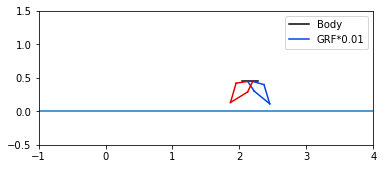

In [22]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [23]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 

In [24]:
N

100

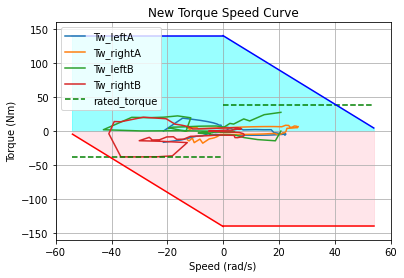

In [25]:
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
if test == 'Periodic_Run':
    csv_file_name = str(int(V_avg))
    
    heading0 = ['node']
    heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
    heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
    heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
    heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB']
    heading = heading0 + heading1 + heading2 + heading3 + heading4
    
    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)
        
        writer.writerow(heading)
        
        for n in range(N):
            node = [n]
            data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
            data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
            data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
            data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
            data = node + data1 + data2 + data3 + data4
            writer.writerow(data)

plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

In [26]:
m.connect_force[50,'Y','B'].value

-59.86093130286617

In [29]:
m.dq[47,'x_body'].value

8.04655274164881

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>

In [28]:
N

100